In [1]:
train_path = r"E:\Semester-7\AI In Healthcare\Project\Fedalyx\data\train"
test_path = r"E:\Semester-7\AI In Healthcare\Project\Fedalyx\data\test"

import os
import glob
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from math import ceil

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
sns.set(style='whitegrid')

In [2]:
def gather_image_info(root_path, subset_name):
    rows = []
    root = Path(root_path)
    if not root.exists():
        return pd.DataFrame(rows)
    for class_dir in sorted([d for d in root.iterdir() if d.is_dir()]):
        class_name = class_dir.name
        pattern = str(class_dir / "**" / "*")
        for fp in glob.glob(pattern, recursive=True):
            if not os.path.isfile(fp):
                continue
            if Path(fp).suffix.lower() not in ['.jpg', '.jpeg', '.png', '.bmp']:
                continue
            try:
                with Image.open(fp) as im:
                    w, h = im.size
            except Exception:
                w, h = (None, None)
            size_kb = round(os.path.getsize(fp) / 1024, 2)
            rows.append({
                'filepath': fp,
                'subset': subset_name,
                'class': class_name,
                'width': w,
                'height': h,
                'aspect_ratio': (w / h) if (w and h) else None,
                'size_kb': size_kb
            })
    return pd.DataFrame(rows)

train_df = gather_image_info(train_path, 'train')
test_df = gather_image_info(test_path, 'test')
df = pd.concat([train_df, test_df], ignore_index=True)

,subset,class,count
0,test,Normal,234
1,test,Pneumonia,390
2,train,Normal,1349
3,train,Pneumonia,3883


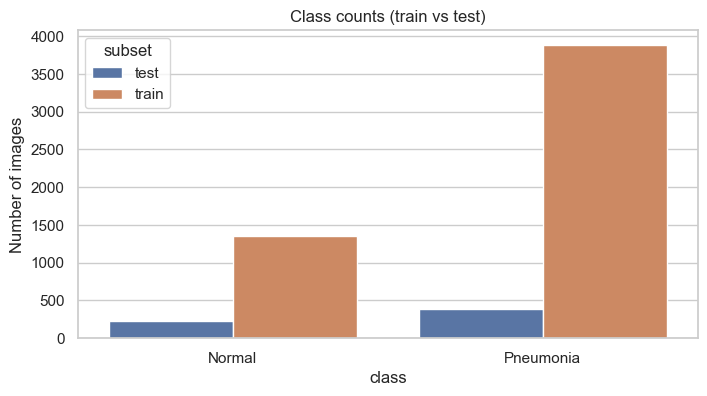

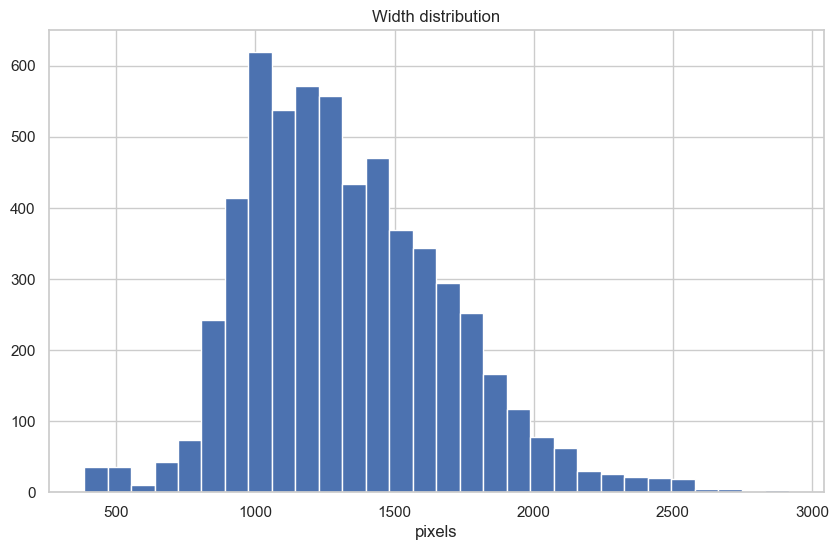

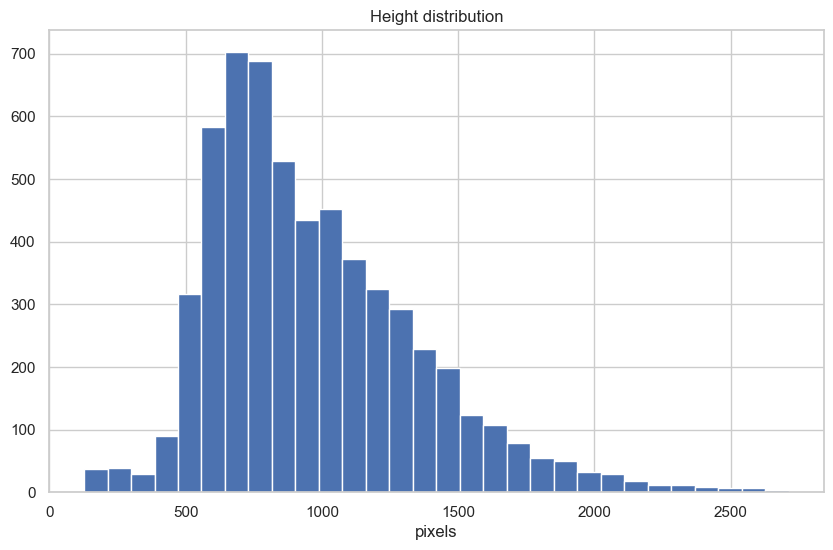

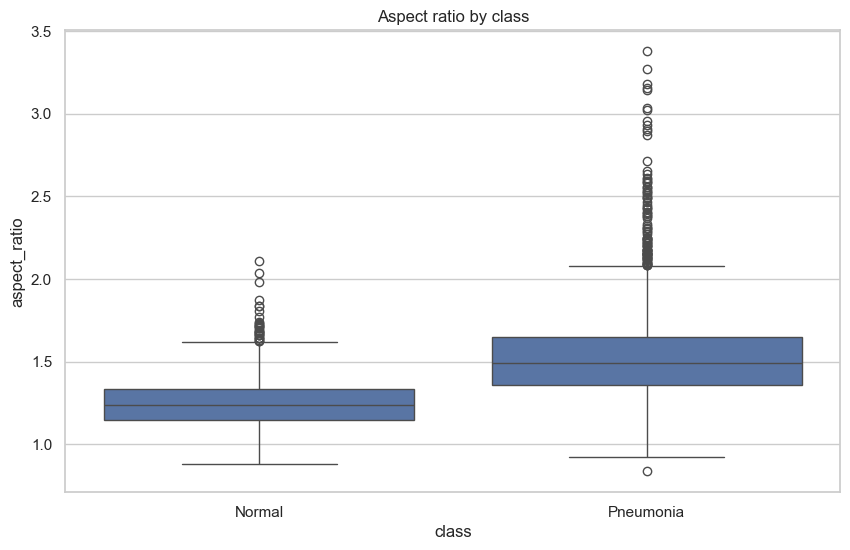

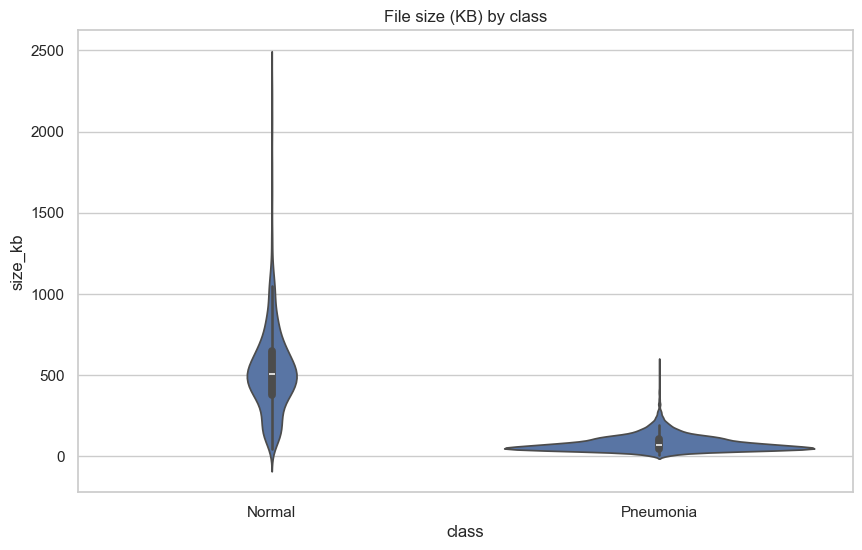

In [3]:
if 'class' not in df.columns or df['class'].isnull().all():
    df['class'] = df['filepath'].apply(lambda p: Path(p).parts[-2] if len(Path(p).parts) >= 2 else 'unknown')

def normalize_cls(c):
    if c is None:
        return 'unknown'
    s = str(c).strip().lower()
    if 'pneu' in s:
        return 'Pneumonia'
    if 'norm' in s:
        return 'Normal'
    return str(c).strip().title()

df['class'] = df['class'].apply(normalize_cls)

if 'subset' not in df.columns or df['subset'].isnull().all():
    def infer_subset(fp):
        p = os.path.normpath(fp).lower()
        if os.path.normpath(str(train_path)).lower() in p:
            return 'train'
        if os.path.normpath(str(test_path)).lower() in p:
            return 'test'
        if '\\train\\' in p or '/train/' in p:
            return 'train'
        if '\\test\\' in p or '/test/' in p:
            return 'test'
        return 'unknown'
    df['subset'] = df['filepath'].apply(infer_subset)

count_df = df.groupby(['subset', 'class']).size().reset_index(name='count')
display(count_df)

plt.figure(figsize=(8,4))
sns.barplot(x='class', y='count', hue='subset', data=count_df)
plt.title('Class counts (train vs test)')
plt.ylabel('Number of images')
plt.show()

size_df = df.dropna(subset=['width','height']).copy()
plt.figure()
plt.hist(size_df['width'], bins=30)
plt.title('Width distribution')
plt.xlabel('pixels')
plt.show()

plt.figure()
plt.hist(size_df['height'], bins=30)
plt.title('Height distribution')
plt.xlabel('pixels')
plt.show()

plt.figure()
sns.boxplot(x='class', y='aspect_ratio', data=size_df)
plt.title('Aspect ratio by class')
plt.show()

plt.figure()
sns.violinplot(x='class', y='size_kb', data=df)
plt.title('File size (KB) by class')
plt.show()

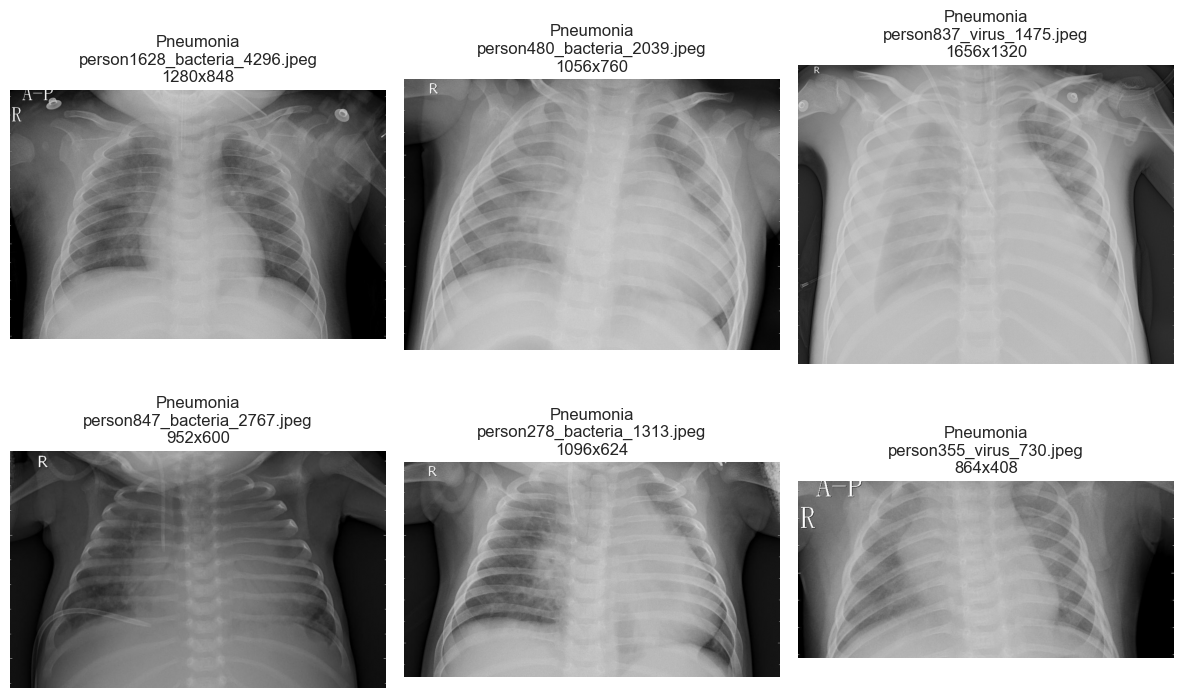

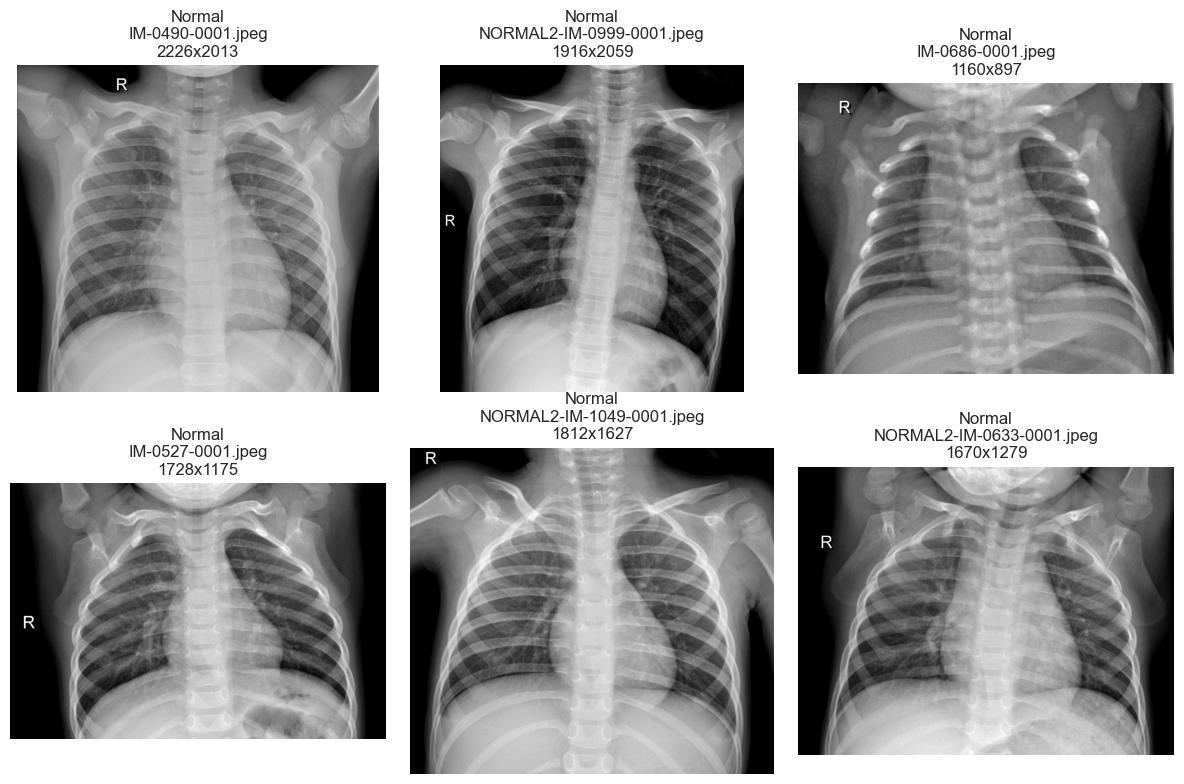

In [4]:
def show_samples(df, cls, subset='train', n=6):
    subset_df = df[(df['class']==cls) & (df['subset']==subset)]
    if subset_df.empty:
        return
    samples = subset_df.sample(min(n, len(subset_df)), random_state=42)
    n = len(samples)
    cols = 3
    rows = ceil(n/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    axes = axes.flatten()
    for ax in axes:
        ax.axis('off')
    for i, (_, r) in enumerate(samples.iterrows()):
        try:
            im = Image.open(r['filepath']).convert('L')
            axes[i].imshow(im, cmap='gray')
            axes[i].set_title(f"{r['class']}\n{os.path.basename(r['filepath'])}\n{r['width']}x{r['height']}")
        except Exception as e:
            axes[i].text(0.5,0.5,'Error', horizontalalignment='center')
    plt.tight_layout()
    plt.show()

show_samples(df, 'Pneumonia', subset='train', n=6)
show_samples(df, 'Normal', subset='train', n=6)

In [5]:
size_df = df.dropna(subset=['width','height']).copy()
n_total = len(df)
n_valid = len(size_df)
n_missing = n_total - n_valid

width_min = int(size_df['width'].min()) if n_valid>0 else None
width_max = int(size_df['width'].max()) if n_valid>0 else None
width_mean = float(size_df['width'].mean()) if n_valid>0 else None
width_median = float(size_df['width'].median()) if n_valid>0 else None
width_std = float(size_df['width'].std()) if n_valid>0 else None
width_percentiles = size_df['width'].quantile([0.10,0.25,0.75,0.90]).to_dict() if n_valid>0 else {}

height_min = int(size_df['height'].min()) if n_valid>0 else None
height_max = int(size_df['height'].max()) if n_valid>0 else None
height_mean = float(size_df['height'].mean()) if n_valid>0 else None
height_median = float(size_df['height'].median()) if n_valid>0 else None
height_std = float(size_df['height'].std()) if n_valid>0 else None
height_percentiles = size_df['height'].quantile([0.10,0.25,0.75,0.90]).to_dict() if n_valid>0 else {}

size_df['aspect_ratio'] = size_df['width'] / size_df['height']
ar_min = float(size_df['aspect_ratio'].min()) if n_valid>0 else None
ar_max = float(size_df['aspect_ratio'].max()) if n_valid>0 else None
ar_mean = float(size_df['aspect_ratio'].mean()) if n_valid>0 else None
ar_median = float(size_df['aspect_ratio'].median()) if n_valid>0 else None
ar_std = float(size_df['aspect_ratio'].std()) if n_valid>0 else None
ar_percentiles = size_df['aspect_ratio'].quantile([0.10,0.25,0.75,0.90]).to_dict() if n_valid>0 else {}

unique_sizes = size_df.groupby(['width','height']).size().reset_index(name='count').sort_values('count', ascending=False)
top_unique_sizes = unique_sizes.head(10).to_dict(orient='records')

recommended_target = None
if n_valid>0:
    med_w = int(round(width_median))
    med_h = int(round(height_median))
    max_med = max(med_w, med_h)
    def next_pow2(x):
        p = 1
        while p < x:
            p <<= 1
        return p
    if max_med <= 224:
        recommended_target = 224
    elif max_med <= 384:
        recommended_target = 384
    elif max_med <= 512:
        recommended_target = 512
    else:
        recommended_target = next_pow2(max_med)

print("NUMERIC SUMMARY")
print("----------------")
print(f"total_images = {n_total}")
print(f"valid_size_images = {n_valid}")
print(f"missing_size_images = {n_missing}")
print("")
print("WIDTH (pixels):")
print(f" min = {width_min}")
print(f" max = {width_max}")
print(f" mean = {width_mean:.2f}" if width_mean is not None else " mean = None")
print(f" median = {width_median}")
print(f" std = {width_std:.2f}" if width_std is not None else " std = None")
print(f" 10th,25th,75th,90th percentiles = { {k:int(v) for k,v in width_percentiles.items()} }")
print("")
print("HEIGHT (pixels):")
print(f" min = {height_min}")
print(f" max = {height_max}")
print(f" mean = {height_mean:.2f}" if height_mean is not None else " mean = None")
print(f" median = {height_median}")
print(f" std = {height_std:.2f}" if height_std is not None else " std = None")
print(f" 10th,25th,75th,90th percentiles = { {k:int(v) for k,v in height_percentiles.items()} }")
print("")
print("ASPECT RATIO (width / height):")
print(f" min = {ar_min:.4f}")
print(f" max = {ar_max:.4f}")
print(f" mean = {ar_mean:.4f}")
print(f" median = {ar_median:.4f}")
print(f" std = {ar_std:.4f}")
print(f" 10th,25th,75th,90th percentiles = { {k:round(v,4) for k,v in ar_percentiles.items()} }")
print("")
print("TOP 10 MOST COMMON (width,height) PAIRS WITH COUNTS:")
for rec in top_unique_sizes:
    print(f" {int(rec['width'])}x{int(rec['height'])} -> {int(rec['count'])}")
print("")
print(f"RECOMMENDED_TARGET_IMAGE_SIZE_FOR_MODEL = {recommended_target}")
print(f"MEDIAN_DIMENSIONS = ({med_w} x {med_h})")
print("")
print("ACTIONABLE INSIGHT NUMERIC GUIDELINES")
print(" 1) If recommended target is <=224 -> use resize to (recommended,recommended) or center crop to preserve details.")
print(" 2) If recommended target between 224 and 512 -> resize with aspect-ratio preservation then pad to square (recommended x recommended).")
print(" 3) If recommended target >512 -> consider downsampling to next power of two ({0}) or use models that accept larger inputs.".format(recommended_target))


NUMERIC SUMMARY
----------------
total_images = 5856
valid_size_images = 5856
missing_size_images = 0

WIDTH (pixels):
 min = 384
 max = 2916
 mean = 1327.88
 median = 1281.0
 std = 363.50
 10th,25th,75th,90th percentiles = {0.1: 920, 0.25: 1056, 0.75: 1560, 0.9: 1808}

HEIGHT (pixels):
 min = 127
 max = 2713
 mean = 970.69
 median = 888.0
 std = 383.39
 10th,25th,75th,90th percentiles = {0.1: 568, 0.25: 688, 0.75: 1187, 0.9: 1488}

ASPECT RATIO (width / height):
 min = 0.8354
 max = 3.3788
 mean = 1.4430
 median = 1.4159
 std = 0.2544
 10th,25th,75th,90th percentiles = {0.1: 1.1526, 0.25: 1.2616, 0.75: 1.5858, 0.9: 1.75}

TOP 10 MOST COMMON (width,height) PAIRS WITH COUNTS:
 1072x648 -> 7
 1008x704 -> 7
 992x608 -> 6
 1216x872 -> 6
 992x592 -> 6
 1080x728 -> 6
 1192x760 -> 5
 1088x712 -> 5
 976x672 -> 5
 1000x704 -> 5

RECOMMENDED_TARGET_IMAGE_SIZE_FOR_MODEL = 2048
MEDIAN_DIMENSIONS = (1281 x 888)

ACTIONABLE INSIGHT NUMERIC GUIDELINES
 1) If recommended target is <=224 -> use resize 

In [6]:
sample_paths = df['filepath'].sample(min(50, len(df)), random_state=42).tolist()

channels_list = []
mode_list = []

for p in sample_paths:
    try:
        im = Image.open(p)
        mode_list.append(im.mode)
        if im.mode == 'L':
            channels_list.append(1)
        elif im.mode == 'RGB':
            channels_list.append(3)
        else:
            channels_list.append(len(im.getbands()))
    except:
        pass

unique_modes = list(set(mode_list))
unique_channels = list(set(channels_list))

mode_counts = {m: mode_list.count(m) for m in unique_modes}
channel_counts = {c: channels_list.count(c) for c in unique_channels}

print("COLOR CHANNEL ANALYSIS")
print("----------------------")
print(f"Total samples checked: {len(mode_list)}")
print(f"Image modes found: {mode_counts}")
print(f"Channel counts found: {channel_counts}")

if 3 in unique_channels and 1 in unique_channels:
    print("\nMost likely: Images saved as RGB but visually grayscale (common in JPEG datasets).")
elif 3 in unique_channels:
    print("\nImages stored as 3-channel RGB.")
elif 1 in unique_channels:
    print("\nImages stored as single-channel Grayscale (ideal for CXR).")

print("\nACTIONABLE INSIGHT")
if 1 in unique_channels:
    print(" → You can safely use 1 input channel (C=1) for your CNN.")
elif 3 in unique_channels:
    print(" → Images are stored in RGB. You may convert to grayscale to reduce memory usage.")


COLOR CHANNEL ANALYSIS
----------------------
Total samples checked: 50
Image modes found: {'L': 47, 'RGB': 3}
Channel counts found: {1: 47, 3: 3}

Most likely: Images saved as RGB but visually grayscale (common in JPEG datasets).

ACTIONABLE INSIGHT
 → You can safely use 1 input channel (C=1) for your CNN.


In [7]:
from PIL import Image, ImageStat
import numpy as np
import cv2

corrupted_files = []
small_images = []
blurry_images = []
brightness_outliers = []
contrast_outliers = []

sharpness_values = []
brightness_values = []
contrast_values = []

for fp in df['filepath']:
    try:
        im = Image.open(fp).convert('L')
        arr = np.array(im)

        h, w = arr.shape
        if h < 200 or w < 200:
            small_images.append(fp)

        lap_var = cv2.Laplacian(arr, cv2.CV_64F).var()
        sharpness_values.append(lap_var)
        if lap_var < 40:
            blurry_images.append(fp)

        stat = ImageStat.Stat(im)
        mean_brightness = stat.mean[0]
        brightness_values.append(mean_brightness)

        contrast = stat.stddev[0]
        contrast_values.append(contrast)

    except Exception:
        corrupted_files.append(fp)

brightness_q1 = np.percentile(brightness_values, 5)
brightness_q9 = np.percentile(brightness_values, 95)

contrast_q1 = np.percentile(contrast_values, 5)
contrast_q9 = np.percentile(contrast_values, 95)

for fp, b, c in zip(df['filepath'], brightness_values, contrast_values):
    if b < brightness_q1 or b > brightness_q9:
        brightness_outliers.append(fp)
    if c < contrast_q1 or c > contrast_q9:
        contrast_outliers.append(fp)

print("OUTLIER / LOW-QUALITY IMAGE ANALYSIS")
print("------------------------------------")
print(f"Corrupted images: {len(corrupted_files)}")
print(f"Small images (<200px): {len(small_images)}")
print(f"Blurry images (low sharpness): {len(blurry_images)}")
print(f"Brightness outliers: {len(brightness_outliers)}")
print(f"Contrast outliers: {len(contrast_outliers)}")

print("\nExamples:")
print("Corrupted:", corrupted_files[:5])
print("Small:", small_images[:5])
print("Blurry:", blurry_images[:5])
print("Brightness outliers:", brightness_outliers[:5])
print("Contrast outliers:", contrast_outliers[:5])


OUTLIER / LOW-QUALITY IMAGE ANALYSIS
------------------------------------
Corrupted images: 0
Small images (<200px): 32
Blurry images (low sharpness): 279
Brightness outliers: 586
Contrast outliers: 586

Examples:
Corrupted: []
Small: ['E:\\Semester-7\\AI In Healthcare\\Project\\Fedalyx\\data\\train\\PNEUMONIA\\person1311_bacteria_3312.jpeg', 'E:\\Semester-7\\AI In Healthcare\\Project\\Fedalyx\\data\\train\\PNEUMONIA\\person1669_bacteria_4422.jpeg', 'E:\\Semester-7\\AI In Healthcare\\Project\\Fedalyx\\data\\train\\PNEUMONIA\\person1676_bacteria_4441.jpeg', 'E:\\Semester-7\\AI In Healthcare\\Project\\Fedalyx\\data\\train\\PNEUMONIA\\person1677_bacteria_4444.jpeg', 'E:\\Semester-7\\AI In Healthcare\\Project\\Fedalyx\\data\\train\\PNEUMONIA\\person1679_bacteria_4448.jpeg']
Blurry: ['E:\\Semester-7\\AI In Healthcare\\Project\\Fedalyx\\data\\train\\PNEUMONIA\\person1035_bacteria_2969.jpeg', 'E:\\Semester-7\\AI In Healthcare\\Project\\Fedalyx\\data\\train\\PNEUMONIA\\person1038_bacteria_2972